In [28]:
import findspark
findspark.init()
import pyspark

# imports
import pandas as pd
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

def encode_data(df, categorical_cols, numeric_cols, predict_col, encode_predict_col):
    """
    Args:
        categorical_cols (list): list of collumns to be one-hot encoded (does not include predict_col for classification)
        numeric_cols (list): numeric columns
        predict_col (string): attribute to predict
        encode_predict_col (boolean): should the predict_col be encoded (classification) or not (regression)
    Returns:
        DataFrame with columns
            'label': one hot encoded label column for classification. Not included for regression
            'features': numeric and one hot encoded variables. Included for both classificaiton and regression
    """
    cols = df.columns
    stages = []
    # one hot encoding stages for categorical predictor variables
    for categoricalCol in categorical_cols:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]
    # possibly one hot encode the predict_col if this is a classification problem
    predict_col_tf = predict_col
    if encode_predict_col:
        predict_col_tf = 'label'
        predict_col_stringIdx = StringIndexer(inputCol = predict_col, outputCol=predict_col_tf)
        stages += [predict_col_stringIdx]
    assemblerInputs = [c + "classVec" for c in categorical_cols] + numeric_cols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    # pipeline stages
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    df = pipelineModel.transform(df)
    # return appropriote subset of DataFrame
    selectedCols = [predict_col_tf,'features']
    df = df.select(selectedCols)
    return df

def summarize_df(session,df,numeric_cols):
    """
    Summarize the dataframe attributes
    Args:
        session (SparkSession): active SparkSession
        df (DataFrame): dataframe of interest
        numeric_cols (list): list of numeric_attribute names
    """
    df.createOrReplaceTempView('dfsql')
    for col_str in df.schema.names:
        print ('col:'),col_str 
        if col_str in numeric_cols:
            df.describe(col_str).show()
        else:
            dftmp = session.sql('select %s, count(*) as count from dfsql group by %s'%(col_str,col_str)).show()
    df.printSchema()
    df.show(20)



In [44]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.sql.types import *

# setup
spark = SparkSession.builder.master("local").appName('auto').getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

# read data
struct = StructType([
    StructField('label', FloatType(), True), # mpg
    StructField('cylinders', StringType(), True),
    StructField('displacement', FloatType(), True),
    StructField('horsepower', FloatType(), True),
    StructField('weight', FloatType(), True),    
    StructField('acceleration', FloatType(), True),    
    StructField('model_year', StringType(), True),  
    StructField('origin', StringType(), True),  
    StructField('car_name', StringType(), True)])
df = spark.read.schema(struct).csv('C:/csp554_bdt_fp-master/data/auto/auto-mpg.csv',header=False)
df.printSchema()
df.show(5)

# drop (total 7) cars with 4 or 3 cylinders
df = df.filter((df['cylinders']!='3') & (df['cylinders']!='5'))

# fill missing horsepower values with column mean 
imputer = Imputer(strategy='mean',inputCols=['horsepower'],outputCols=['horsepower'])
model = imputer.fit(df)
df = model.transform(df)

# drop car_name, the unique id column 
df = df.drop('car_name')

# summarize dataframe
numeric_cols = [col for col,dtype in df.dtypes if dtype=='float']
summarize_df(spark,df,numeric_cols)


# Create a vector column composed of all the features
feature_cols = ['displacement', 'horsepower', 'weight', 'acceleration']

other_cols = ['label']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_unscaled')
features_df = assembler.transform(df)

features_df.show(5)

# one hot encoding
df = encode_data(df,
        categorical_cols = ['cylinders','model_year','origin'],
        numeric_cols = ['displacement','horsepower','weight','acceleration'],
        predict_col = 'label',
        encode_predict_col = False)

# split into train and test datsets
train,test = df.randomSplit([.75,.25], seed=7)


root
 |-- label: float (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- displacement: float (nullable = true)
 |-- horsepower: float (nullable = true)
 |-- weight: float (nullable = true)
 |-- acceleration: float (nullable = true)
 |-- model_year: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- car_name: string (nullable = true)

+-----+---------+------------+----------+------+------------+----------+------+--------------------+
|label|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+-----+---------+------------+----------+------+------------+----------+------+--------------------+
| 18.0|        8|       307.0|     130.0|3504.0|        12.0|        70|     1|chevrolet chevell...|
| 15.0|        8|       350.0|     165.0|3693.0|        11.5|        70|     1|   buick skylark 320|
| 18.0|        8|       318.0|     150.0|3436.0|        11.0|        70|     1|  plymouth satellite|
| 16.0|        8|       304

# Correlation Matrix

In [45]:
from pyspark.ml.stat import Correlation
# Get correlation DataFrame, collect and extract a pyspark.mllib.linalg.DenseMatrix, convert to array 
corr_mat = Correlation.corr(features_df, 'features_unscaled').collect()[0][0].toArray()

# Create Pandas DataFrame from correlation matrix
corr_mat = pd.DataFrame(corr_mat, index=feature_cols, columns=feature_cols)
corr_mat.head(len(feature_cols))

,displacement,horsepower,weight,acceleration
displacement,1.000000,0.899001,0.935108,-0.560377
horsepower,0.899001,1.000000,0.864853,-0.686990
weight,0.935108,0.864853,1.000000,-0.431552
acceleration,-0.560377,-0.686990,-0.431552,1.000000


In [46]:
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
    wsseList = []	
    for k in clusters:
        print("Training for cluster size {} ".format(k))
        kmeans = KM(k = k, seed = 1)
        model = kmeans.fit(elbowset)
        transformed = model.transform(elbowset)
        featuresAndPrediction = transformed.select("features", "prediction")

        W = computeCost(featuresAndPrediction, model)
        print("......................WSSE = {} ".format(W))

        wsseList.append(W)
    return wsseList

def elbow_plot(wsseList, clusters):
    wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
    wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data, P, ylim=[-3,+3], figsize=(15,8), colors=None):
    
    my_colors = colors
    if my_colors is None:
        my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'c', 'k', 'm']), None, len(P)))
        
    plt.figure(figsize=figsize).gca().axes.set_ylim(ylim)
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    # return my_colors
    
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar

    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.
    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.
    
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Correlation Plot (heat map)

C:\Users\Harshit Paliwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


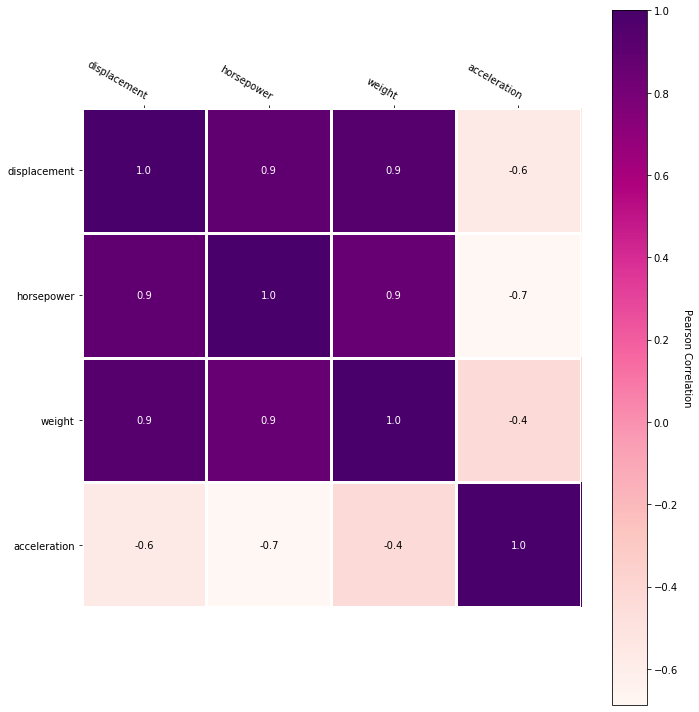

In [47]:
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(corr_mat, feature_cols, feature_cols, ax=ax,
                         cmap="RdPu", cbarlabel="Pearson Correlation")

texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [48]:
train_df, test_df = features_df.randomSplit([0.75, 0.25], seed=7)
train_df.count(), test_df.count()

(280, 111)

# K-means

In [49]:

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(train_df)

train_df = scalerModel.transform(train_df)
test_df = scalerModel.transform(test_df)

train_df.show(5)      
test_df.show(5)

+-----+---------+------------+----------+------+------------+----------+------+--------------------+--------------------+
|label|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|   features_unscaled|            features|
+-----+---------+------------+----------+------+------------+----------+------+--------------------+--------------------+
| 10.0|        8|       307.0|     200.0|4376.0|        15.0|        70|     1|[307.0,200.0,4376...|[1.09100715466121...|
| 10.0|        8|       360.0|     215.0|4615.0|        14.0|        70|     1|[360.0,215.0,4615...|[1.59553485523217...|
| 11.0|        8|       318.0|     210.0|4382.0|        13.5|        70|     1|[318.0,210.0,4382...|[1.19572045100613...|
| 11.0|        8|       350.0|     180.0|3664.0|        11.0|        73|     1|[350.0,180.0,3664...|[1.50034094946407...|
| 11.0|        8|       400.0|     150.0|4997.0|        14.0|        73|     1|[400.0,150.0,4997...|[1.97631047830460...|
+-----+---------+-------

# WSSE for predicting K value

Trying k from 2 to 7 with 138 samples...

Training for cluster size 2 
......................WSSE = 149.535134174299 
Training for cluster size 3 
......................WSSE = 144.6790298772471 
Training for cluster size 4 
......................WSSE = 120.4867087119345 
Training for cluster size 5 
......................WSSE = 98.31073868505686 
Training for cluster size 6 
......................WSSE = 95.10679658829773 
Training for cluster size 7 
......................WSSE = 88.94969445537834 


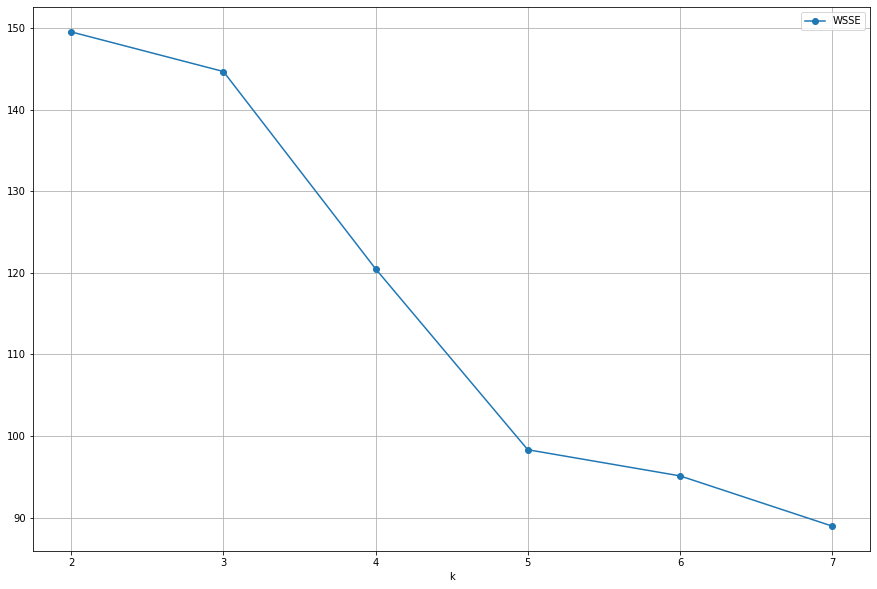

In [50]:
# Only need to run this once to find value(s) to try for k
create_elbow_plot = True # Set to False if already know value for k


if create_elbow_plot == True:
    # lower the sample fraction to decrease fit time (with the risk of worse results)
    sampled = train_df.sample(.5)

    k_attempts = range(2,8)
    print('Trying k from {} to {} with {} samples...\n'.format(list(k_attempts)[0],
                                                               list(k_attempts)[-1],
                                                               sampled.count()))

    wsseList = elbow(sampled, k_attempts)
    elbow_plot(wsseList, k_attempts)
    
    



# Silhouete score

In [51]:
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KM(k = 3 , seed = 7)
model = kmeans.fit(train_df)
transformed = model.transform(train_df)
featuresAndPrediction = transformed.select("features", "prediction")

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5460449806268687
Cluster Centers: 
[-0.52824779 -0.40116217 -0.52270134 -0.09926044]
[ 1.51994805  1.5217688   1.40501462 -1.11820762]
[-0.37346141 -0.64045154 -0.2734346   1.29294804]


# Bisecting k-means

In [52]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(7)
model = bkm.fit(train_df)

# Evaluate clustering.
cost = model.computeCost(train_df)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 303.6710712958164
Cluster Centers: 
[-0.81009733 -0.66831629 -0.83080605  0.28256986]
[ 0.14550012 -0.12246682  0.28846029  0.48165812]
[ 1.51994805  1.5217688   1.40501462 -1.11820762]


# Gaussian Mixture Model (GMM)

In [53]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(3).setSeed(7)
model = gmm.fit(train_df)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+---------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                                             |cov                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------+----